![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


In [7]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


#### Inferencias 

##### Season

- En Invierno (1) se evidencia una menor cantidad promedio de 116 bicicletas rentadas, una mediana de 78 y un máximo de 801. 
- En Verano (3) evidencia la mayor cantidad promedio de 234 bicicletas rentadas, una mediana de 195 y un máximo de 977.

##### Hour

- Se evidencia la mayor concentración de cantidad promedio de bicicletas entre las 7h y 8h y entre las 16h y las 18h. 
- Se evidencia la menor concentración de cantidad promedio de bicicletas entre las 23h y las 6h. 


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

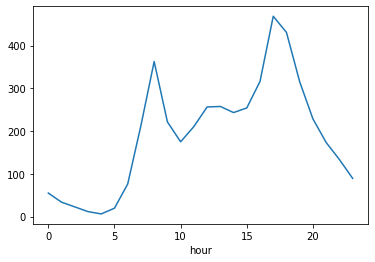

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

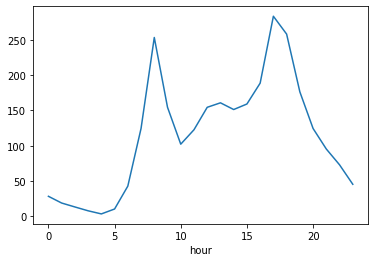

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

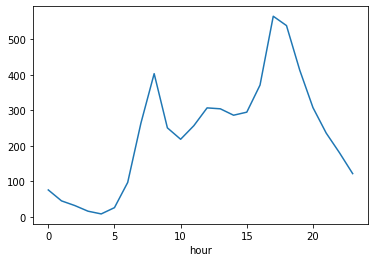

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot()

#### Interpretación

Al comparar la distribución de las bicicletas rentadas por hora no cambia entre estaciones, lo que sí se evidencia es una volumetría mayor durante el verano llegando a un máximo de 550 aprox, mientras que en invierno se llega a un máximo de 300 aprox.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3

#XTotal = bikes[['season','hour']]
XTotal = bikes.iloc[:,[0,11]]
yTotal = bikes.total

XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

reg = LinearRegression().fit(XTrain, yTrain)

score = reg.score(XTrain, yTrain)
y_pred = reg.predict(XTest)

MSE = np.average(np.square(y_pred-yTest))

print("El Score R2 del modelo de regresión lineal es: " + str(score))
print("El MSE del modelo PCA es: " + str(MSE))


El Score R2 del modelo de regresión lineal es: 0.19308102375746472
El MSE del modelo PCA es: 26895.62015728526


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [14]:
# Celda 4
# Definición de parámetros y criterios de parada
max_depth = None # Profundidad
num_pct = 10 # Percentiles 
max_features = None # Máximo de características
min_gain=0.001 # ganancia minima

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(XTrain, yTrain, 5)
j, split, gain

# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = XTrain.iloc[:, j] < split

y_l = yTrain.loc[filter_l]
y_r = yTrain.loc[~filter_l]

yTrain.shape[0], y_l.shape[0], y_r.shape[0]
yTrain.mean(), y_l.mean(), y_r.mean()

(189.627313862608, 32.450256889304065, 254.9448757763975)

#### Crecimiento recursivo del árbol

In [15]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree_grow(XTrain, yTrain, level=0, min_gain=0.001, max_depth=1, num_pct=10)
tree = tree_grow(XTrain, yTrain, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 189.5754626456477,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 7293,
 'gain': 18468.385092517958,
 'sl': {'y_pred': 1,
  'y_prob': 53.810755336617405,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 2434,
  'gain': 6695.472699532862,
  'sl': {'y_pred': 1,
   'y_prob': 32.42043863742417,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 2141,
   'gain': 602.8207067436908,
   'sl': {'y_pred': 1,
    'y_prob': 25.225806451612904,
    'level': 3,
    'split': -1,
    'n_samples': 1827,
    'gain': 398.9725847695497},
   'sr': {'y_pred': 1,
    'y_prob': 73.86075949367088,
    'level': 3,
    'split': -1,
    'n_samples': 314,
    'gain': 596.4506420522612}},
  'sr': {'y_pred': 1,
   'y_prob': 208.8372881355932,
   'level': 2,
   'split': [0, 2.0],
   'n_samples': 293,
   'gain': 4671.176444058714,
   'sl': {'y_pred': 1,
    'y_prob': 121.3972602739726,
    'level': 3,
    'split': -1,
    'n_samples': 71,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_prob':

#### Realizar predicciones usando el árbol creado

In [16]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
y_pred = tree_predict(XTest, tree)

In [17]:
MSE = np.sqrt(mean_squared_error(y_pred, yTest))
print("El MSE del modelo árbol de decisión manual es: " + str(MSE))

El MSE del modelo árbol de decisión manual es: 265.54790571760253


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'Accuracy')

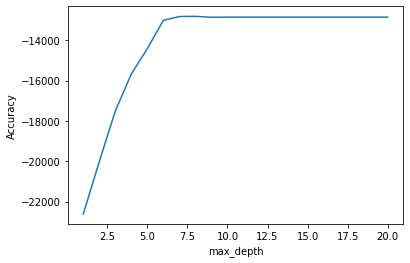

In [18]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, XTrain, yTrain, cv=50, scoring='neg_mean_squared_error').mean())

# Gráfica max_depth versus RMSE (error del modelo)
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')    

In [19]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=6, random_state=1)
clf.fit(XTrain, yTrain)

DecisionTreeRegressor(max_depth=6, random_state=1)

In [20]:
clf.feature_importances_

array([0.1298542, 0.8701458])

In [21]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
feature_cols = XTrain.columns
feature_cols
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
0,season,0.129854
1,hour,0.870146


In [22]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, XTrain, yTrain, cv=10)).describe()

count    10.000000
mean      0.600684
std       0.019117
min       0.557733
25%       0.594879
50%       0.606841
75%       0.615330
max       0.617889
dtype: float64

In [23]:
yPred = clf.predict(XTest)

In [24]:
MSE = np.sqrt(mean_squared_error(yPred, yTest))
print("El MSE del modelo árbol de decisión con sklearn es: " + str(MSE))

El MSE del modelo árbol de decisión con sklearn es: 116.76821006467736


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [25]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [26]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [27]:
# División de la muestra en set de entrenamiento y prueba
##from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

#### Regresión Logística

In [28]:
# Celda 6

RegLog= LogisticRegression(random_state=0,max_iter=10000)
RegLog.fit(X_train,y_train)
prediccionesRegLog=RegLog.predict(X_test)
# Matríz de confusión de la regresión logística
print('Esta es la matriz de confusión de la regresión logística:')
print(confusion_matrix(y_true=y_test, y_pred=prediccionesRegLog))

accuracyRegLog=accuracy_score(y_true=y_test, y_pred=prediccionesRegLog)
print('El Accuracy de regresión logística es:' + str(accuracyRegLog))

f1scoreRegLog = f1_score(y_true=y_test, y_pred=prediccionesRegLog, average='weighted')
print('El F1 score de regresión logística es:' + str(f1scoreRegLog))


Esta es la matriz de confusión de la regresión logística:
[[493 251]
 [315 441]]
El Accuracy de regresión logística es:0.6226666666666667
El F1 score de regresión logística es:0.6221078771999772


#### Árbol de clasificación

In [29]:
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X_train, y_train)

prediccionesArbol = clf.predict(X_test)

# Matríz de confusión del árbol de decisión
print('Esta es la matriz de confusión del árbol de decisión:')
print(confusion_matrix(y_true=y_test, y_pred=prediccionesArbol))

accuracyArbol=accuracy_score(y_true=y_test, y_pred=prediccionesArbol)
print('El Accuracy del árbol de decisión es:' + str(accuracyArbol))

f1scoreArbol = f1_score(y_true=y_test, y_pred=prediccionesArbol, average='weighted')
print('El F1 score del árbol de decisión es:' + str(f1scoreArbol))

feature_cols = X_train.columns
feature_cols
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')


Esta es la matriz de confusión del árbol de decisión:
[[523 221]
 [302 454]]
El Accuracy del árbol de decisión es:0.6513333333333333
El F1 score del árbol de decisión es:0.6504654088050316


,feature,importance
0,timedelta,0.000000
30,weekday_is_monday,0.000000
31,weekday_is_tuesday,0.000000
32,weekday_is_wednesday,0.000000
33,weekday_is_thursday,0.000000
34,weekday_is_friday,0.000000
35,weekday_is_saturday,0.000000
36,weekday_is_sunday,0.000000
37,is_weekend,0.000000
38,LDA_00,0.000000


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [30]:
# Celda 7

from sklearn.ensemble import VotingClassifier
n_estimators = 100
np.random.seed(123)

clf1 = DecisionTreeClassifier(max_depth=100, random_state=1)
clf2 = DecisionTreeClassifier(min_samples_leaf = 2,  random_state=1)
clf3 = LogisticRegression(random_state=0,max_iter=10000)

eclf1 = VotingClassifier(estimators=[
        ('dtc1',BaggingClassifier(base_estimator=clf1, n_estimators=n_estimators, random_state=123)) ,
        ('dtc2',BaggingClassifier(base_estimator=clf2, n_estimators=n_estimators, random_state=123)) ,
        ('lr',BaggingClassifier(base_estimator=clf3, n_estimators=n_estimators, random_state=123)) ]
        , voting='hard')

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
eclf1.fit(X_train, y_train)

prediccionesArbol1 = clf1.predict(X_test)
prediccionesArbol2 = clf2.predict(X_test)
prediccionesRegLog = clf3.predict(X_test)
prediccion_ensamble = eclf1.predict(X_test)


accuracyArbol1=accuracy_score(y_true=y_test, y_pred=prediccionesArbol1)
accuracyArbol2=accuracy_score(y_true=y_test, y_pred=prediccionesArbol2)
accuracyRegLog=accuracy_score(y_true=y_test, y_pred=prediccionesRegLog)
accuracyEnsamble=accuracy_score(y_true=y_test, y_pred=prediccion_ensamble)

f1scoreArbol1 = f1_score(y_true=y_test, y_pred=prediccionesArbol1, average='weighted')
f1scoreArbol2 = f1_score(y_true=y_test, y_pred=prediccionesArbol2, average='weighted')
f1scoreRegLog = f1_score(y_true=y_test, y_pred=prediccionesRegLog, average='weighted')
f1scoreEnsamble = f1_score(y_true=y_test, y_pred=prediccion_ensamble, average='weighted')

# Comparar los resultados
print(f"Resultados de los modelos individuales:")
print(f"El modelo Árbol de Decisión 1, donde max_depth toma un valor de su elección:")
print(f"Tiene un accuracy = "+ str(accuracyArbol1) + " y un F1-Score ="+ str(f1scoreArbol1))
print(f"El modelo Árbol de Decisión 2, donde min_samples_leaf toma un valor de su elección:")
print(f"Tiene un accuracy = "+ str(accuracyArbol2) + " y un F1-Score ="+ str(f1scoreArbol2))
print(f"El modelo Regresión Logística:")
print(f"Tiene un accuracy = "+ str(accuracyRegLog) + " y un F1-Score ="+ str(f1scoreRegLog))
print(f"El modelo Ensamble de Votación Mayoritaria:")
print(f"Tiene un accuracy = "+ str(accuracyEnsamble) + " y un F1-Score ="+ str(f1scoreEnsamble))


Resultados de los modelos individuales:
El modelo Árbol de Decisión 1, donde max_depth toma un valor de su elección:
Tiene un accuracy = 0.5426666666666666 y un F1-Score =0.5426341442601033
El modelo Árbol de Decisión 2, donde min_samples_leaf toma un valor de su elección:
Tiene un accuracy = 0.5473333333333333 y un F1-Score =0.5464892627215706
El modelo Regresión Logística:
Tiene un accuracy = 0.6226666666666667 y un F1-Score =0.6221078771999772
El modelo Ensamble de Votación Mayoritaria:
Tiene un accuracy = 0.6366666666666667 y un F1-Score =0.6366451861832053


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [31]:
# Celda 8

eclf2 = VotingClassifier(estimators=[
        ('dtc1',BaggingClassifier(base_estimator=clf1, n_estimators=n_estimators, random_state=123)) ,
        ('dtc2',BaggingClassifier(base_estimator=clf2, n_estimators=n_estimators, random_state=123)) ,
        ('lr',BaggingClassifier(base_estimator=clf3, n_estimators=n_estimators, random_state=123)) ]
        , voting='soft') # , weights=[1,1,1]

eclf2.fit(X_train, y_train)

prediccion_ensamble_VP = eclf2.predict(X_test)

accuracyEnsamble_VP=accuracy_score(y_true=y_test, y_pred=prediccion_ensamble_VP)
f1scoreEnsamble_VP = f1_score(y_true=y_test, y_pred=prediccion_ensamble_VP, average='weighted')

# Comparar los resultados
print(f"El modelo Ensamble de Votación Ponderada:")
print(f"Tiene un accuracy = "+ str(accuracyEnsamble_VP) + " y un F1-Score ="+ str(f1scoreEnsamble_VP))


El modelo Ensamble de Votación Ponderada:
Tiene un accuracy = 0.6493333333333333 y un F1-Score =0.6493364505089115


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### Celda 9

El implementar un ensamble de los tres modelos nos permite obtener un mejor Accuracy y F1-Score que el que podríamos obtener a partir de cualquiera de los tres modelos de manera indiviual. 

Al momento de comparar los ensambles,  el ensamble de votación ponderada tiene mejores Accuracy y F1-Score en comparación con el de votación mayoritaria. 


**Votación Ponderada:**


Ventajas:
- Expresión de preferencias fuertes: Permite a los votantes expresar la intensidad de sus preferencias al asignar diferentes pesos a las opciones. Esto es útil cuando algunos temas son más importantes para ciertos votantes.
- Mayor información: Proporciona una medida más rica de las preferencias individuales que el sistema de un voto por persona.

Desventajas:
- Complejidad: Implementar y administrar un sistema de votación ponderada puede ser más complejo.
- Dificultad en la interpretación: Los resultados pueden ser más difíciles de interpretar debido a la variabilidad en los pesos asignados entre los modelos que componen el ensamblaje.


**Votación Mayoritaria:**

Ventajas:
- Simplicidad: Es fácil de entender y aplicar. Cada modelo tiene un voto igual y se toma la decisión basada en la mayoría.
- Robustez: Menos sensible a valores atípicos, ya que se basa en la mayoría.

Desventajas:
- Menos información: No proporciona una medida detallada de las preferencias individuales.
- Posible polarización: Si los modelos son muy diferentes, la votación mayoritaria puede llevar a decisiones extremas.

En resumen, la votación ponderada es más flexible pero más compleja, mientras que la votación mayoritaria es simple pero menos expresiva. 
